<a href="https://colab.research.google.com/github/randomm101/notebooks/blob/main/RL_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# RL Assignment: Flappy Bird Text
Badr-Eddine Marani

In [2]:
!pip install -q git+https://gitlab-research.centralesupelec.fr/stergios.christodoulidis/text-flappy-bird-gym.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 953.8/953.8 kB 5.9 MB/s eta 0:00:00


In [14]:
from __future__ import print_function
from abc import ABCMeta, abstractmethod
import gymnasium as gym
import text_flappy_bird_gym
import numpy as np
import matplotlib.pyplot as plt
from itertools import product
from tqdm.notebook import tqdm
import pandas as pd

def sliding_window(x: list, window_shape=100):
    return pd.Series(x).rolling(window_shape).mean()


# Base Agent

In [15]:
class BaseAgent:
    """Implements the agent for an RL-Glue environment.
    Note:
        agent_init, agent_start, agent_step, agent_end, agent_cleanup, and
        agent_message are required methods.
    """

    __metaclass__ = ABCMeta

    def __init__(self):
        pass

    @abstractmethod
    def agent_init(self, agent_info= {}):
        """Setup for the agent called when the experiment first starts."""

    @abstractmethod
    def agent_start(self, observation):
        """The first method called when the experiment starts, called after
        the environment starts.
        Args:
            observation (Numpy array): the state observation from the environment's evn_start function.
        Returns:
            The first action the agent takes.
        """

    @abstractmethod
    def agent_step(self, reward, observation):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            observation (Numpy array): the state observation from the
                environment's step based, where the agent ended up after the
                last step
        Returns:
            The action the agent is taking.
        """

    @abstractmethod
    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the terminal state.
        """

    @abstractmethod
    def agent_cleanup(self):
        """Cleanup done after the agent ends."""

    @abstractmethod
    def agent_message(self, message):
        """A function used to pass information from the agent to the experiment.
        Args:
            message: The message passed to the agent.
        Returns:
            The response (or answer) to the message.
        """

# Expected Sarsa Agent

In [16]:
class ExpectedSarsaAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.

        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }

        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])

        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.
        self.memo = {}

    def state_to_index(self, state):
        if state not in self.memo.keys():
            self.memo[state] = len(self.memo)
        return self.memo[state]

    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """

        # Choose action using epsilon greedy.
        current_q = self.q[self.state_to_index(state), :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)
        self.prev_state = self.state_to_index(state)
        self.prev_action = action
        return action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """

        # Choose action using epsilon greedy.
        current_q = self.q[self.state_to_index(state),:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)

        pi = (self.epsilon / self.num_actions) * np.ones(self.num_actions)
        pi += (current_q == current_q.max()) * ((1 - self.epsilon) / np.sum(current_q == current_q.max()))
        self.q[self.prev_state, self.prev_action] += self.step_size * (self.discount * np.sum(current_q * pi) + reward - self.q[self.prev_state, self.prev_action])

        self.prev_state = self.state_to_index(state)
        self.prev_action = action
        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.q[self.prev_state, self.prev_action] += self.step_size * (reward - self.q[self.prev_state, self.prev_action])

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

In [24]:
def run_sarsa_agent_single_sweep(
        epsilon = 0.5,
        step_size = 0.5,
        discount = 0.6,
        num_episodes=100
    ):

    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    num_states = env.observation_space[0].n * env.observation_space[1].n
    num_actions = env.action_space.n

    agent = ExpectedSarsaAgent()
    agent_init_info = {
        "num_actions": num_actions,
        "num_states": num_states,
        "epsilon": epsilon,
        "step_size": step_size,
        "discount": discount,
        "seed": 42,
    }
    agent.agent_init(agent_init_info)

    cumm_reward = []
    scores = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        r = 0

        action = agent.agent_start(state)
        reward = 0
        done = False
        while not done:
            action = agent.agent_step(reward, state)
            next_state, reward, done, _, info = env.step(action)
            r += reward
            state = next_state

        agent.agent_end(reward)
        cumm_reward.append(r)
        scores.append(info["score"])

    cumm_reward = sliding_window(cumm_reward)
    scores = sliding_window(scores)
    return cumm_reward, scores, agent


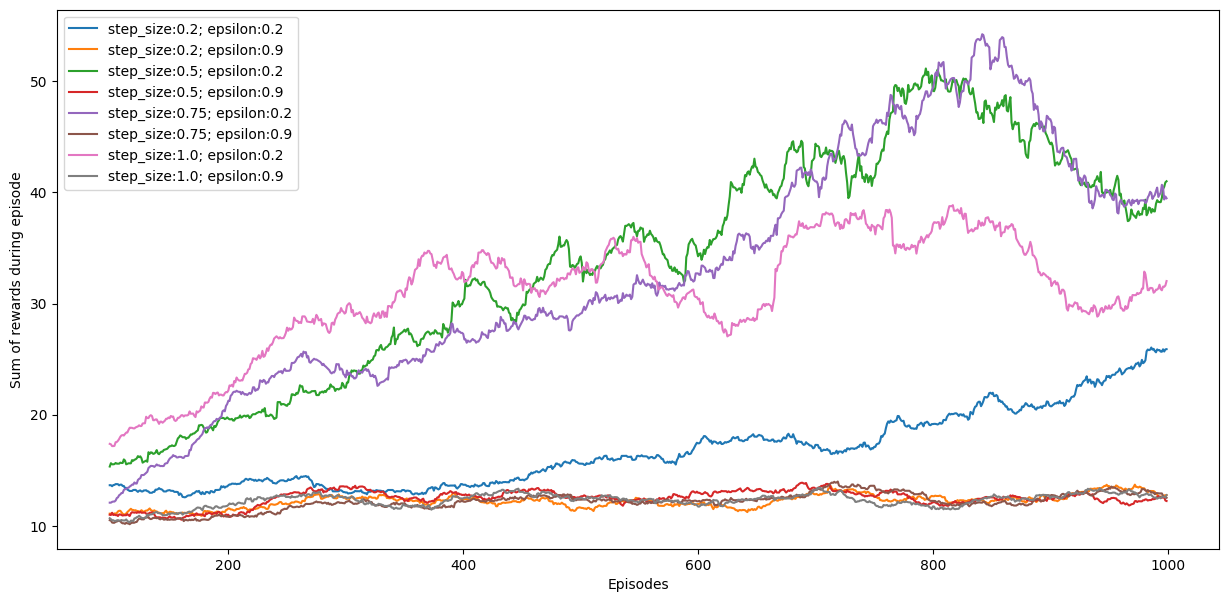

In [21]:
plt.figure(figsize=(15,7))

step_size = [0.20, 0.5, 0.75, 1.0]
epsilon = [0.2, 0.9]
for x in product(step_size, epsilon):
    ss, eps = x
    cumm_reward, _, _ = run_sarsa_agent_single_sweep(step_size=ss, epsilon=eps, num_episodes=1000)
    plt.plot(cumm_reward, label=f"step_size:{ss}; epsilon:{eps}")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Sum of rewards during episode")
plt.savefig("cumm_sum_sarsa.pdf", dpi=300)

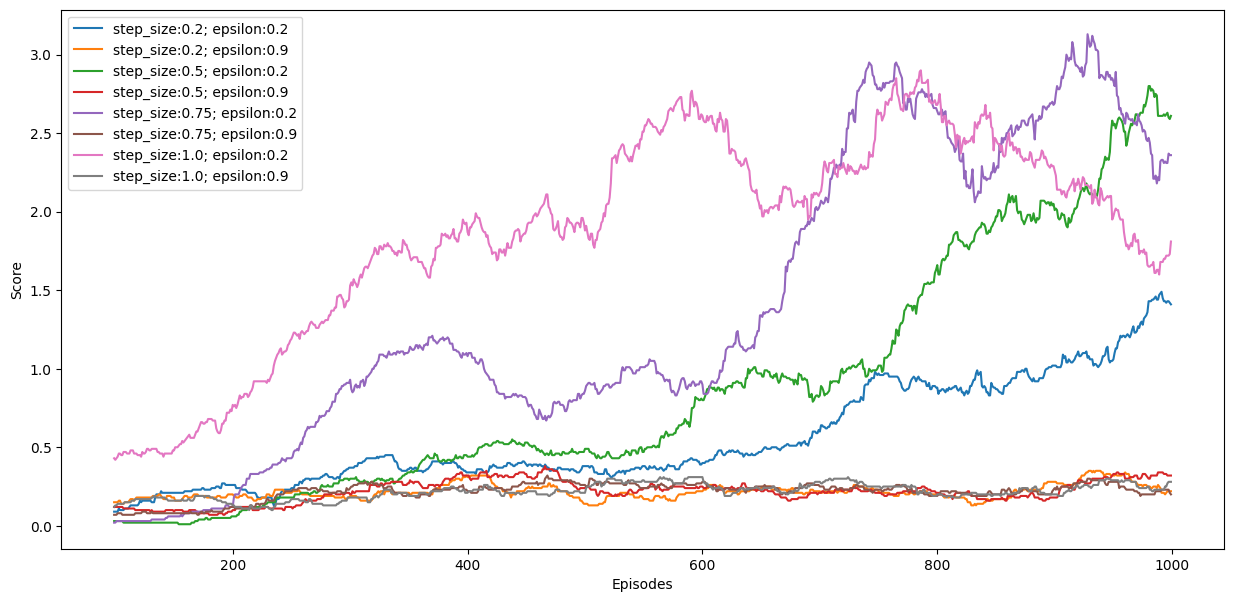

In [22]:
plt.figure(figsize=(15,7))

step_size = [0.20, 0.5, 0.75, 1.0]
epsilon = [0.2, 0.9]
for x in product(step_size, epsilon):
    ss, eps = x
    _, scores, _ = run_sarsa_agent_single_sweep(step_size=ss, epsilon=eps, num_episodes=1000)
    plt.plot(scores, label=f"step_size:{ss}; epsilon:{eps}")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Score")
plt.savefig("scores_sarsa.pdf", dpi=300)


## Monte Carlo Agent

In [46]:
class MCAgent(BaseAgent):
    def agent_init(self, agent_init_info):
        """Setup for the agent called when the experiment first starts.

        Args:
        agent_init_info (dict), the parameters used to initialize the agent. The dictionary contains:
        {
            num_states (int): The number of states,
            num_actions (int): The number of actions,
            epsilon (float): The epsilon parameter for exploration,
            step_size (float): The step-size,
            discount (float): The discount factor,
        }

        """
        # Store the parameters provided in agent_init_info.
        self.num_actions = agent_init_info["num_actions"]
        self.num_states = agent_init_info["num_states"]
        self.epsilon = agent_init_info["epsilon"]
        self.step_size = agent_init_info["step_size"]
        self.discount = agent_init_info["discount"]
        self.rand_generator = np.random.RandomState(agent_init_info["seed"])

        # Create an array for action-value estimates and initialize it to zero.
        self.q = np.zeros((self.num_states, self.num_actions)) # The array of action-value estimates.
        self.memo = {}

    def state_to_index(self, state):
        if state not in self.memo.keys():
            self.memo[state] = len(self.memo)
        return self.memo[state]


    def agent_start(self, state):
        """The first method called when the episode starts, called after
        the environment starts.
        Args:
            state (int): the state from the
                environment's evn_start function.
        Returns:
            action (int): the first action the agent takes.
        """

        # Choose action using epsilon greedy.
        current_q = self.q[self.state_to_index(state),:]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions) # random action selection
        else:
            action = self.argmax(current_q) # greedy action selection
        self.prev_state = self.state_to_index(state)
        self.prev_action = action
        return action

    def agent_step(self, reward, state):
        """A step taken by the agent.
        Args:
            reward (float): the reward received for taking the last action taken
            state (int): the state from the
                environment's step based on where the agent ended up after the
                last step.
        Returns:
            action (int): the action the agent is taking.
        """

        # Choose action using epsilon greedy.
        current_q = self.q[self.state_to_index(state), :]
        if self.rand_generator.rand() < self.epsilon:
            action = self.rand_generator.randint(self.num_actions)
        else:
            action = self.argmax(current_q)

        self.q[self.prev_state, self.prev_action] += self.step_size * (self.discount * current_q.max() + reward - self.q[self.prev_state, self.prev_action])

        self.prev_state = self.state_to_index(state)
        self.prev_action = action
        return action

    def agent_end(self, reward):
        """Run when the agent terminates.
        Args:
            reward (float): the reward the agent received for entering the
                terminal state.
        """
        self.q[self.prev_state, self.prev_action] += self.step_size * (reward - self.q[self.prev_state, self.prev_action])

    def argmax(self, q_values):
        """argmax with random tie-breaking
        Args:
            q_values (Numpy array): the array of action-values
        Returns:
            action (int): an action with the highest value
        """
        top = float("-inf")
        ties = []

        for i in range(len(q_values)):
            if q_values[i] > top:
                top = q_values[i]
                ties = []

            if q_values[i] == top:
                ties.append(i)

        return self.rand_generator.choice(ties)

In [47]:
def run_monte_carlo_agent_single_sweep(
        epsilon = 0.5,
        step_size = 0.5,
        discount = 0.6,
        num_episodes=100
    ):

    env = gym.make('TextFlappyBird-v0', height=15, width=20, pipe_gap=4)
    num_states = env.observation_space[0].n * env.observation_space[1].n
    num_actions = env.action_space.n

    agent = MCAgent()
    agent_init_info = {
        "num_actions": num_actions,
        "num_states": num_states,
        "epsilon": epsilon,
        "step_size": step_size,
        "discount": discount,
        "seed": 42,
    }
    agent.agent_init(agent_init_info)

    cumm_reward = []
    scores = []

    for episode in range(num_episodes):
        state, _ = env.reset()
        r = 0

        action = agent.agent_start(state)
        reward = 0
        done = False
        while not done:
            action = agent.agent_step(reward, state)
            next_state, reward, done, _, info = env.step(action)
            r += reward
            state = next_state

        agent.agent_end(reward)
        scores.append(info["score"])
        cumm_reward.append(r)

    cumm_reward = sliding_window(cumm_reward)
    scores = sliding_window(scores)
    return cumm_reward, scores, agent


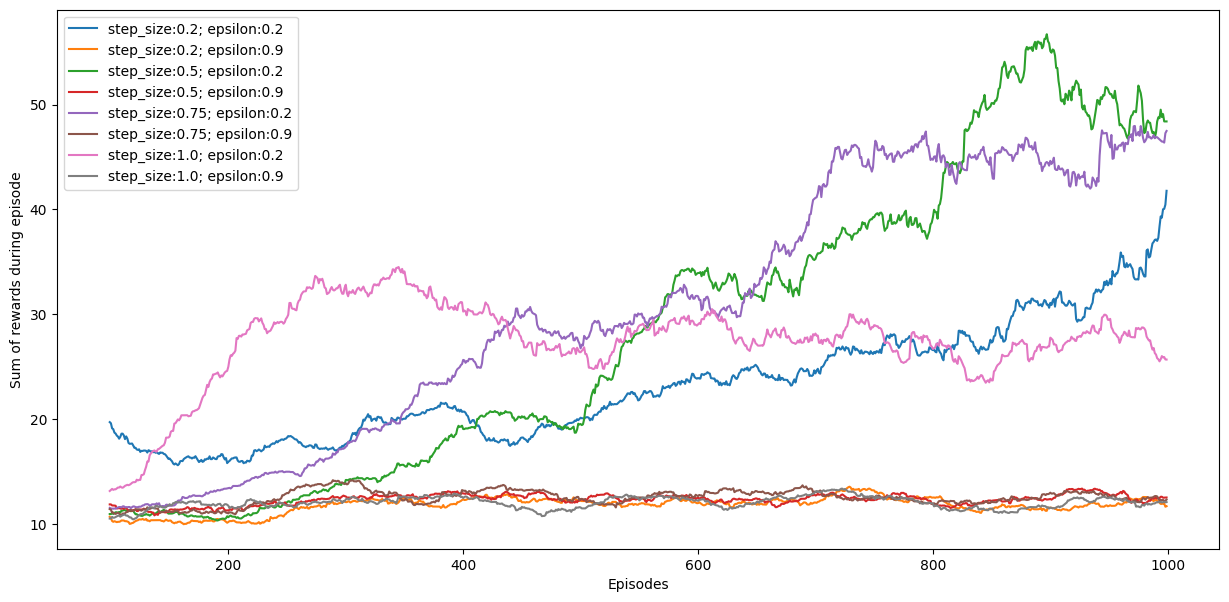

In [51]:
plt.figure(figsize=(15,7))

step_size = [0.20, 0.5, 0.75, 1.0]
epsilon = [0.2, 0.9]
for x in product(step_size, epsilon):
    ss, eps = x
    cumm_reward, _, _ = run_monte_carlo_agent_single_sweep(step_size=ss, epsilon=eps, num_episodes=1000)
    plt.plot(cumm_reward, label=f"step_size:{ss}; epsilon:{eps}")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Sum of rewards during episode")
plt.savefig("mc_cumm_sum.pdf", dpi=300)

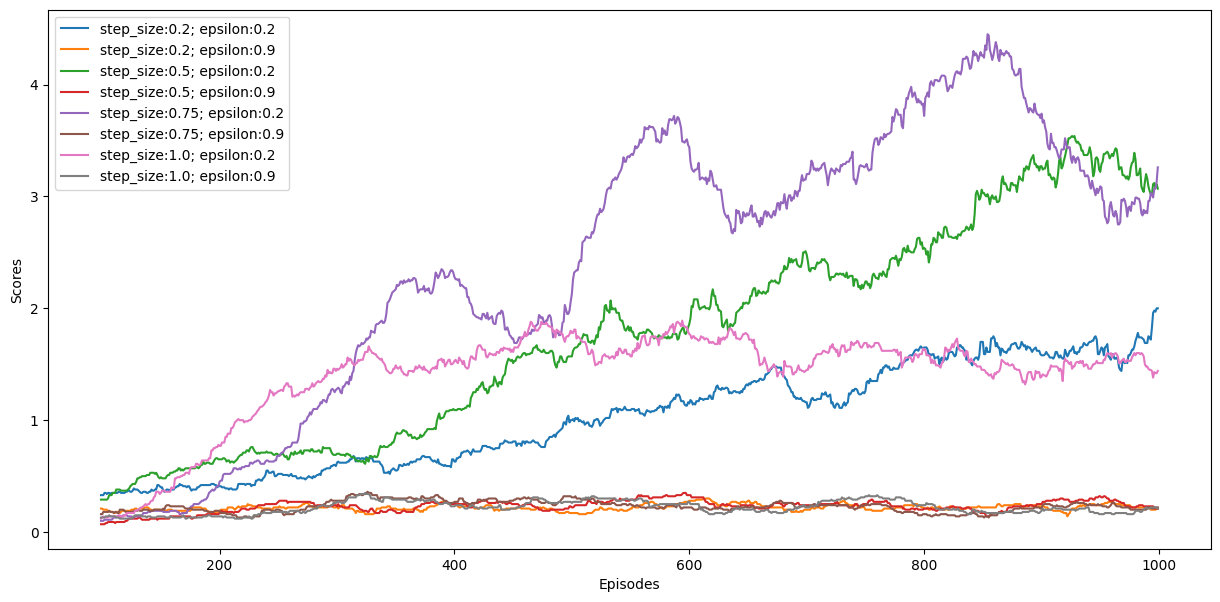

In [56]:
plt.figure(figsize=(15,7))

step_size = [0.20, 0.5, 0.75, 1.0]
epsilon = [0.2, 0.9]
for x in product(step_size, epsilon):
    ss, eps = x
    _, scores, _ = run_monte_carlo_agent_single_sweep(step_size=ss, epsilon=eps, num_episodes=1000)
    plt.plot(scores, label=f"step_size:{ss}; epsilon:{eps}")
plt.legend()
plt.xlabel("Episodes")
plt.ylabel("Scores")
plt.savefig("mc_scores.pdf", dpi=300)